TODO:
- Add evaluation of validation data

In [1]:
from __future__ import division

from utils import *
from prep_data import *

import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime
from datetime import date
from datetime import timedelta
from dateutil.parser import parse

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from ggplot import *

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [191]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))

In [251]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']

In [379]:
take_diff = True

In [380]:
X = np.load(os.path.join(dir_data, 'X.npy'))
Y = np.load(os.path.join(dir_data, 'Y.npy'))
x_house = np.load(os.path.join(dir_data, 'x_house.npy'))
x_date = np.load(os.path.join(dir_data, 'x_date.npy'))

In [381]:
X, Y, x_house, x_date = shuffle(X, Y, x_house, x_date, random_state=0)

In [382]:
# Remove bad series with negative values.

# idx = np.random.randint(X.shape[0], size=100)
# sns.distplot(X[idx].flatten())

mask_keep = np.array([min(x)>=0 for (i, x) in enumerate(X)])
print 'removing {} series for having negative values...'.format(len(X) - sum(mask_keep))
X = X[mask_keep]
Y = Y[mask_keep]
x_house = x_house[mask_keep]
x_date = x_date[mask_keep]

removing 6 series for having negative values...


In [383]:
# Choose an appliance to model.

# y = Y[:,0]  # fridge
y = [y_row[0] for y_row in Y]  # fridge
y = np.array(y)
y = y.reshape(y.shape[0], 1)

In [384]:
# Preprocss.

# Take first-difference (if desired).
if take_diff:
    X = np.diff(X)
    zs = np.zeros((X.shape[0], 1), dtype=int)
    X = np.concatenate((zs, X), axis=1)  # pad beginning with zeros to preserve shape
    
# Scale data.
scaler_x = StandardScaler().fit(X)
# scaler_y = StandardScaler().fit(y)
X = scaler_x.transform(X)
# y = scaler_y.transform(y)

In [385]:
# Reshape as tensor.
image_data_format = K.image_data_format()  # 'channels_last'
if image_data_format == 'channels_last':
    X = X.reshape(X.shape[0], X.shape[1], 1)
    input_shape = (N_PER_DAY, 1)
elif image_data_format == 'channels_first':
    X = X.reshape(X.shape[0], 1, X.shape[1])
    input_shape = (1, N_PER_DAY)
else:
    raise ValueError

In [386]:
kernel_size = 3
strides = 1
start_filters = 8
pool_size = 2

model = Sequential()
model.add(Conv1D(start_filters,
                 kernel_size,
                 strides=strides,
                 activation='relu',
                 input_shape=input_shape,
                 padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Conv1D(start_filters*2, kernel_size, strides=strides, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size, padding='same'))
# model.add(Conv1D(start_filters*2**2, kernel_size, strides=strides, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softplus'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse', 'mae', 'mape'])

In [387]:
# def dist_fun(y, min_y=None, inverse=False):
#     if min_y is None and not inverse:
#         min_y = min(y)
#         return (1/(y - min_y + 1), min_y)
#     elif min_y is not None and inverse:
#         return 1/y + min_y - 1
#     else:
#         raise ValueError

# def dist_fun(y):
#     return y
        
# # sns.distplot(y)
# # y_inv, min_y = dist_fun(y)
# # y_recovered = dist_fun(y_inv, min_y=min_y, inverse=True)
# # print y[:3]
# # print y_recovered[:3]
# # sns.distplot(dist_fun(y_inv, min_y=min_y, inverse=True))

In [388]:
# DID NOT TAKE DIFFS OF X

print type(X), X.shape
print type(y), y.shape

history = model.fit(X, y, epochs=3, batch_size=32)

<type 'numpy.ndarray'> (7554, 14400, 1)
<type 'numpy.ndarray'> (7554, 1)
Epoch 1/3
7554/7554 [==============================] - 84s - loss: 0.4429 - mean_squared_error: 0.4429 - mean_absolute_error: 0.4724 - mean_absolute_percentage_error: 75844666.7541       

['mean_squared_error', 'loss', 'mean_absolute_error', 'mean_absolute_percentage_error']


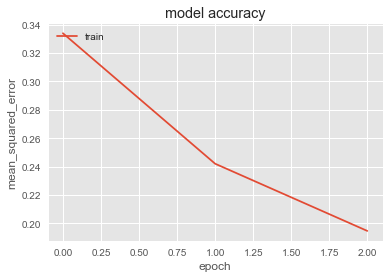

In [361]:
print(history.history.keys())
# summarize history for mse
plt.plot(history.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [367]:
# loss_and_metrics = model.evaluate(X, y, )
y_hat = model.predict(X)
# Y_hat = model.predict(X)

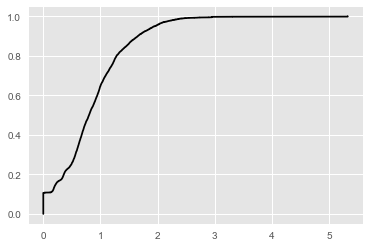

In [434]:
# print np.argwhere(y_hat > 5)
# y_hat[1643]

# https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python

def plot_empir_cum(x):
    return plt.step(sorted(x), np.arange(len(x))/len(x), color='black')

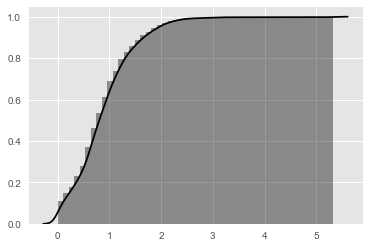

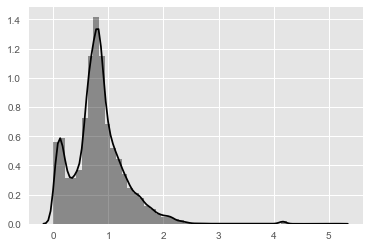

In [409]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')
sns.distplot(y, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(y_hat, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show()

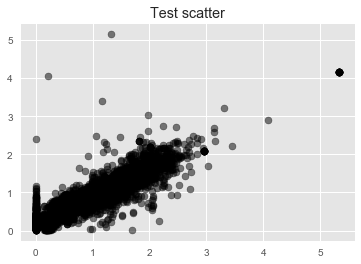

In [378]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

fig = plt.figure()
ax = fig.add_subplot(111, title="Test scatter")
ax.scatter(y, y_hat, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)